### Package loading

In [172]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.float_format', '{:.3f}'.format)

In [309]:
figsize=(11,8)

### Loading data

In [173]:
clust_data = pd.read_excel("Online Retail.xlsx")
clust_data_cp = pd.read_excel("Online Retail.xlsx")

In [174]:
clust_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.550,17850.000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.750,17850.000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.390,17850.000,United Kingdom


In [175]:
clust_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [176]:
clust_data.shape

(541909, 8)

### Feature engineering

In [177]:
clust_data["Order_price"]=clust_data["Quantity"]*clust_data["UnitPrice"]
clust_data["Order_status"]=["Done" if order_price>0 else "Cancelled" for order_price in clust_data["Order_price"]]
clust_data["Year"]=clust_data["InvoiceDate"].dt.year
clust_data["Month"]=clust_data["InvoiceDate"].dt.month
clust_data["Day"]=clust_data["InvoiceDate"].dt.day
clust_data["Hour"]=clust_data["InvoiceDate"].dt.hour
clust_data["Minute"]=clust_data["InvoiceDate"].dt.minute

In [305]:
# import pycountry
# def get_country_id(country):
#     country_info = pycountry.countries.get(name = country)
#     country_id = country_info.numeric
#     return country_id

In [299]:
from sklearn.preprocessing import OrdinalEncoder
# encode countries with number
ord_enc = OrdinalEncoder()
clust_data['Country_id'] = ord_enc.fit_transform(clust_data[['Country']])
clust_data['Country_id'] = clust_data['Country_id'].astype(int)

In [301]:
clust_data['Country_id'].value_counts()

36    494024
14      9495
13      8557
10      8196
31      2533
24      2371
3       2069
33      2002
27      1519
0       1259
25      1086
19       803
6        758
12       695
7        622
32       462
37       446
1        401
9        389
20       358
26       341
18       297
34       291
16       288
30       229
17       182
5        151
15       146
23       127
35        68
11        61
28        58
21        45
22        35
4         32
8         30
2         19
29        10
Name: Country_id, dtype: int64

In [178]:
# first sale
idx_sale_first = clust_data['InvoiceDate'].idxmin()
sale_first = clust_data.iloc[idx_sale_first]
print(sale_first)

# last sale
idx_sale_last = clust_data['InvoiceDate'].idxmax()
sale_last = clust_data.iloc[idx_sale_last]
print(sale_last)

InvoiceNo                                   536365
StockCode                                   85123A
Description     WHITE HANGING HEART T-LIGHT HOLDER
Quantity                                         6
InvoiceDate                    2010-12-01 08:26:00
UnitPrice                                    2.550
CustomerID                               17850.000
Country                             United Kingdom
Order_price                                 15.300
Order_status                                  Done
Year                                          2010
Month                                           12
Day                                              1
Hour                                             8
Minute                                          26
Name: 0, dtype: object
InvoiceNo                         581587
StockCode                          22631
Description     CIRCUS PARADE LUNCH BOX 
Quantity                              12
InvoiceDate          2011-12-09 12:50:00
UnitPri

### Data wrangling

In [179]:
## How many not defined data per columns

clust_data.isna().sum()

InvoiceNo            0
StockCode            0
Description       1454
Quantity             0
InvoiceDate          0
UnitPrice            0
CustomerID      135080
Country              0
Order_price          0
Order_status         0
Year                 0
Month                0
Day                  0
Hour                 0
Minute               0
dtype: int64

In [180]:
clust_data[clust_data["Order_status"]=="Cancelled"].isna().sum()

InvoiceNo          0
StockCode          0
Description     1454
Quantity           0
InvoiceDate        0
UnitPrice          0
CustomerID      2860
Country            0
Order_price        0
Order_status       0
Year               0
Month              0
Day                0
Hour               0
Minute             0
dtype: int64

In [181]:
cancelled=clust_data[clust_data["Order_status"]=="Cancelled"]
Done=clust_data[clust_data["Order_status"]=="Done"]

In [182]:
cancelled[cancelled["Description"].isna()].groupby("Country").count()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Order_price,Order_status,Year,Month,Day,Hour,Minute
Country,,,,,,,,,,,,,,
United Kingdom,1454,1454,0,1454,1454,1454,0,1454,1454,1454,1454,1454,1454,1454


For orders without `Description` label have all 0.0 as `UnitPrice` then it is difficult to track these product and at the same time we haven't `CustomerID`. Then these rows can't be useful for this clutering, subquently we will drop then from our data.

In [183]:
clust_data=clust_data[clust_data["Description"].notna()]
clust_data["CustomerID"]=clust_data["CustomerID"].astype("object")

### Data description

In [184]:
### Data description

clust_data[["Quantity","UnitPrice","Order_price"]].describe()

,Quantity,UnitPrice,Order_price
count,540455.000,540455.000,540455.000
mean,9.603,4.624,18.036
std,218.008,96.890,379.319
min,-80995.000,-11062.060,-168469.600
25%,1.000,1.250,3.480
50%,3.000,2.080,9.840
75%,10.000,4.130,17.400
max,80995.000,38970.000,168469.600


- We have `std` high than `mean` for both variables Quantity and UnitPrice.Then we have a high varaiance in our data that can be explain by pareto law as 20% of customers create 80% turnover. And also the products have a significant difference in price.

- As mentionned in InvoiceNo we have some orders cancelled, the most high number of items order cancelled is 80995 with 168469 `Money Unit`.

- Finally our data is very skewed as we can noticed with std>mean, that can lead by considering some observation as outliers.

<AxesSubplot: xlabel='Country'>

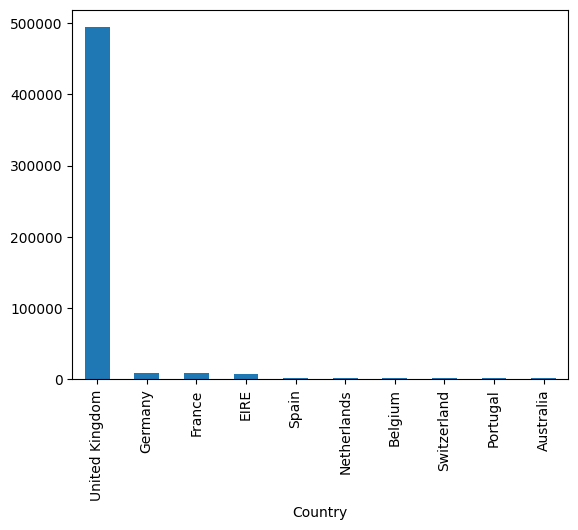

In [314]:
order_per_country=clust_data.groupby("Country").count().sort_values(by="StockCode",ascending=False)

order_per_country["StockCode"].iloc[:10].plot(kind="bar")

<AxesSubplot: xlabel='Description'>

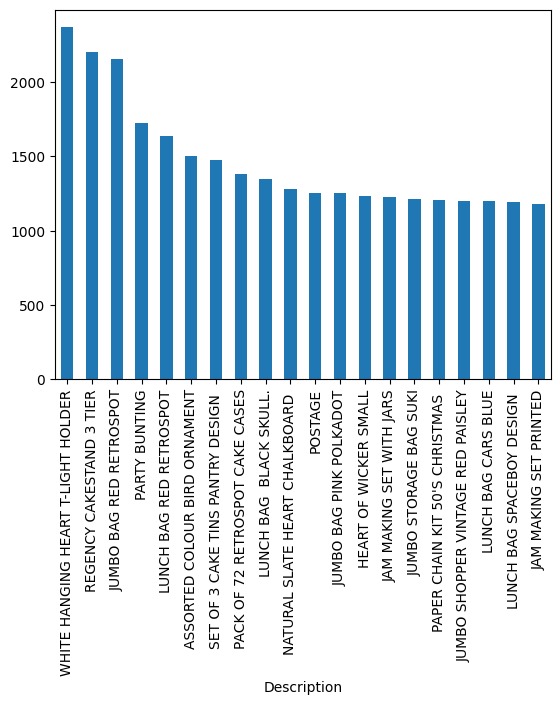

In [186]:
order_per_product=clust_data.groupby("Description").count().sort_values(by="StockCode",ascending=False)

order_per_product["StockCode"].iloc[:20].plot(kind="bar")

In [187]:
clust_data["Description"].nunique()

4223

<AxesSubplot: xlabel='Month'>

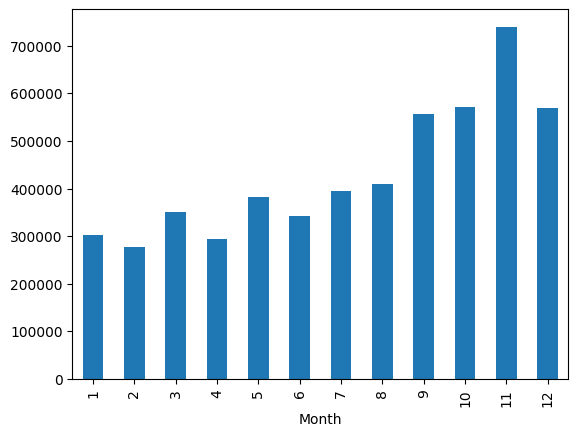

In [188]:
clust_data.groupby("Month").sum()["Quantity"].plot(kind="bar")

<AxesSubplot: xlabel='Day'>

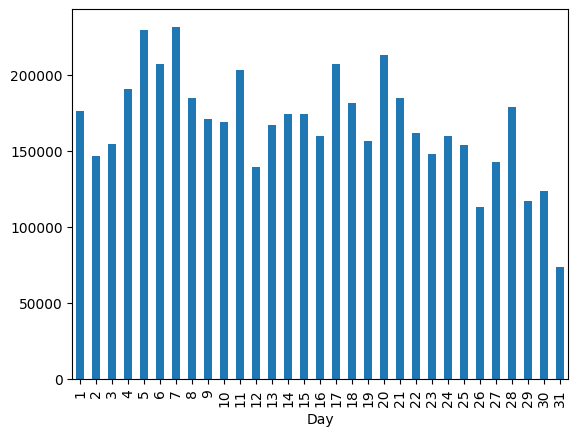

In [189]:
clust_data.groupby("Day").sum()["Quantity"].plot(kind="bar")

<AxesSubplot: xlabel='Hour'>

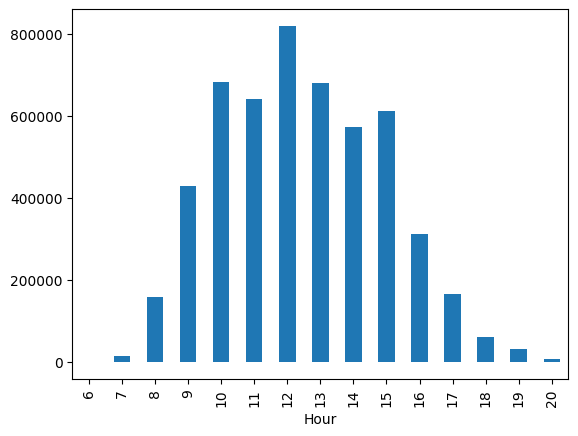

In [190]:
clust_data.groupby("Hour").sum()["Quantity"].plot(kind="bar")

<AxesSubplot: xlabel='Order_status'>

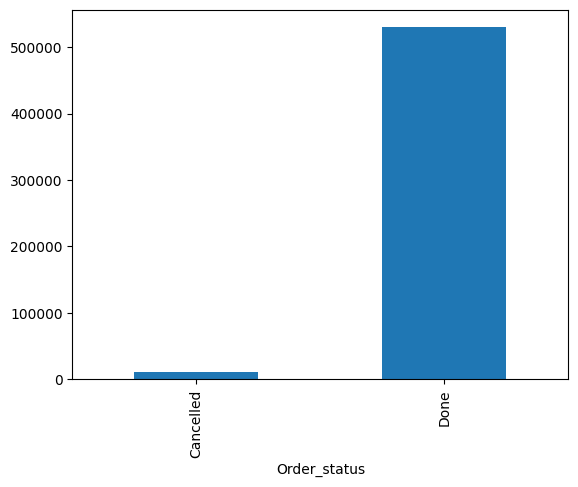

In [191]:
clust_data.groupby("Order_status").count()["InvoiceNo"].plot(kind="bar")

In [310]:
def show_corr(clust_data):
    corr = clust_data.corr()
    plt.figure(figsize=figsize)
    sns.heatmap(corr, cmap="Blues", annot=True, fmt='.2g')
    plt.show()

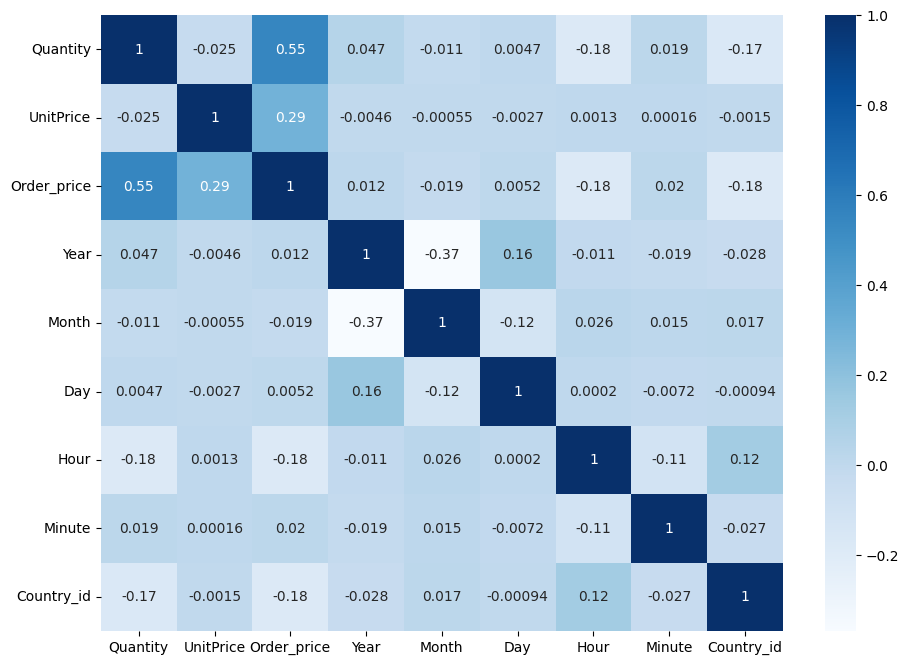

In [311]:
show_corr(clust_data)

<AxesSubplot: >

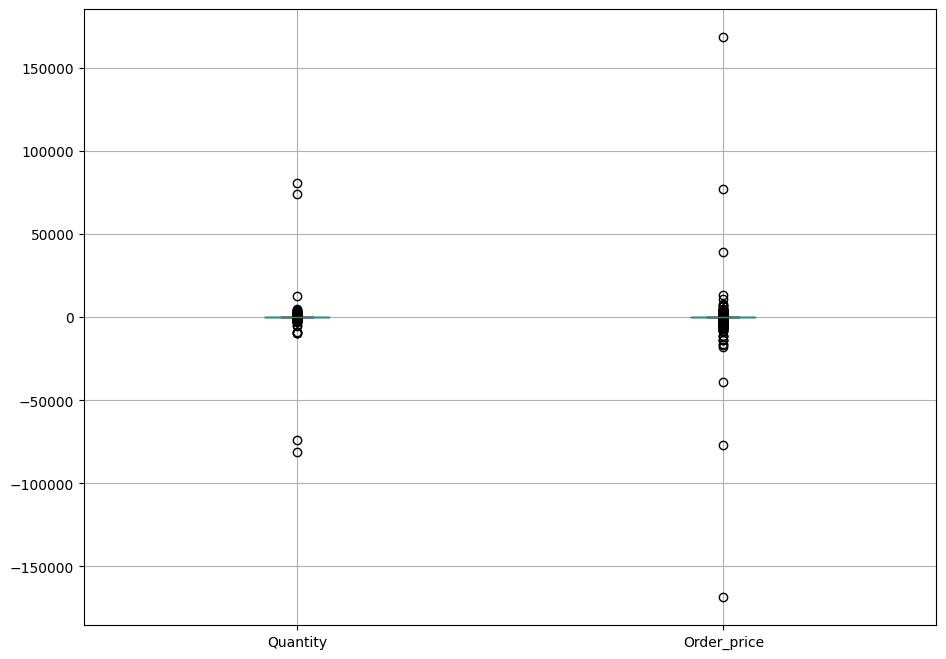

In [194]:
clust_data[['Quantity', 'Order_price']].boxplot(figsize=figsize)

### Remove outliers

In [195]:
def remove_outliers(column):
    Q1 = column.quantile(.25)
    Q3 = column.quantile(.75)
    IQR = Q3 - Q1
    border_left = Q1 - 1.5 * IQR
    border_right = Q3 + 1.5 * IQR
    column = column[
        (border_left <= column) & (column  <= border_right)
    ]
    
    return column

In [196]:
clust_data.Quantity = remove_outliers(clust_data.Quantity)
clust_data.Order_price = remove_outliers(clust_data.Order_price)

<AxesSubplot: >

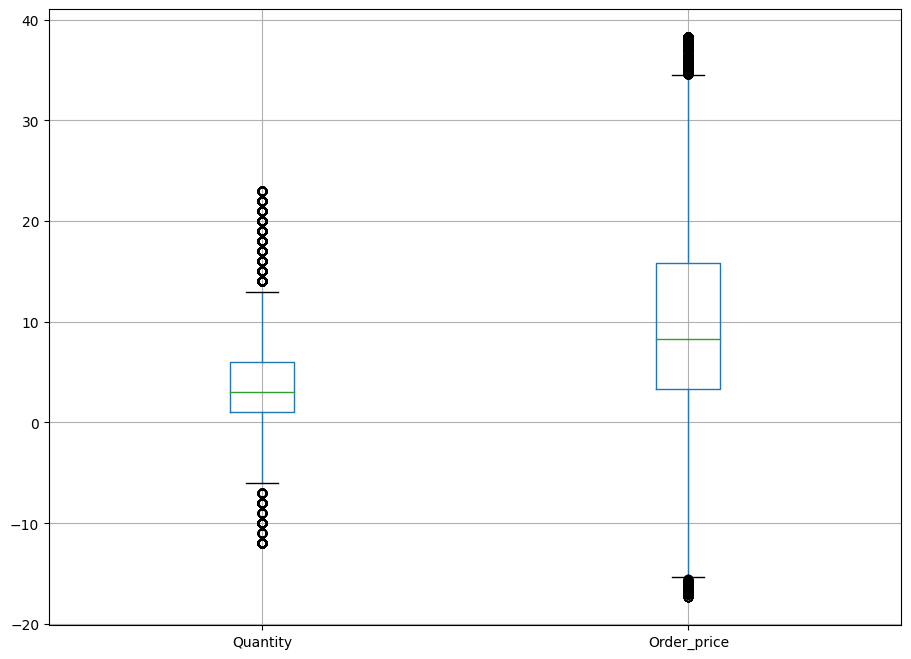

In [197]:
clust_data[['Quantity', 'Order_price']].boxplot(figsize=figsize)

In [198]:
clust_data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Order_price', 'Order_status',
       'Year', 'Month', 'Day', 'Hour', 'Minute'],
      dtype='object')

In [333]:
col_test = ['Order_price', 'Country_id', 'Year', 'Month', 'Day', 'Hour', 'Minute']

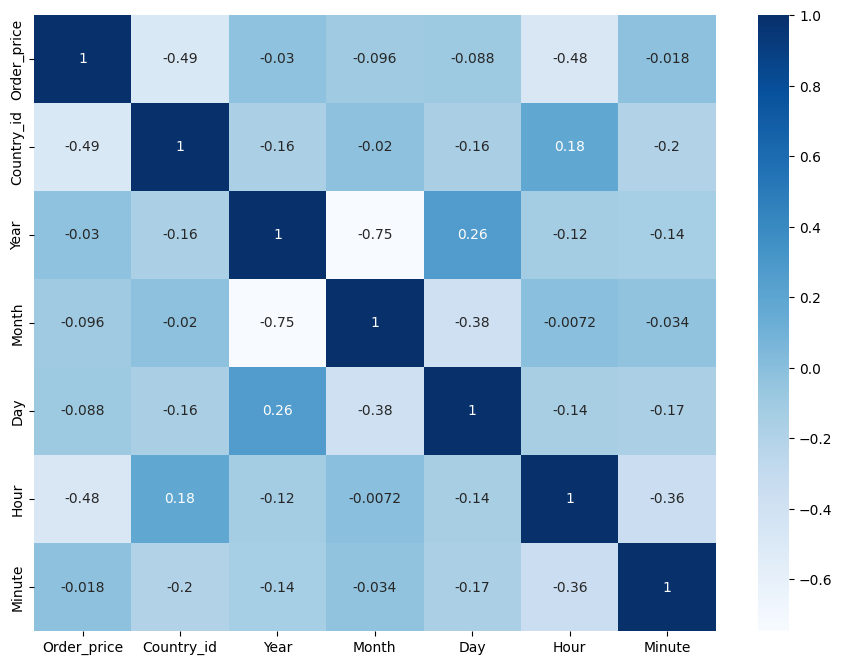

In [334]:
best_f = clust_data[col_test].corr()
show_corr(best_f)

In [341]:
clust_data.dropna(subset = ['Order_price'],inplace = True)
data_final = clust_data[col_test]

In [342]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495395 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Order_price  495395 non-null  float64
 1   Country_id   495395 non-null  int64  
 2   Year         495395 non-null  int64  
 3   Month        495395 non-null  int64  
 4   Day          495395 non-null  int64  
 5   Hour         495395 non-null  int64  
 6   Minute       495395 non-null  int64  
dtypes: float64(1), int64(6)
memory usage: 30.2 MB


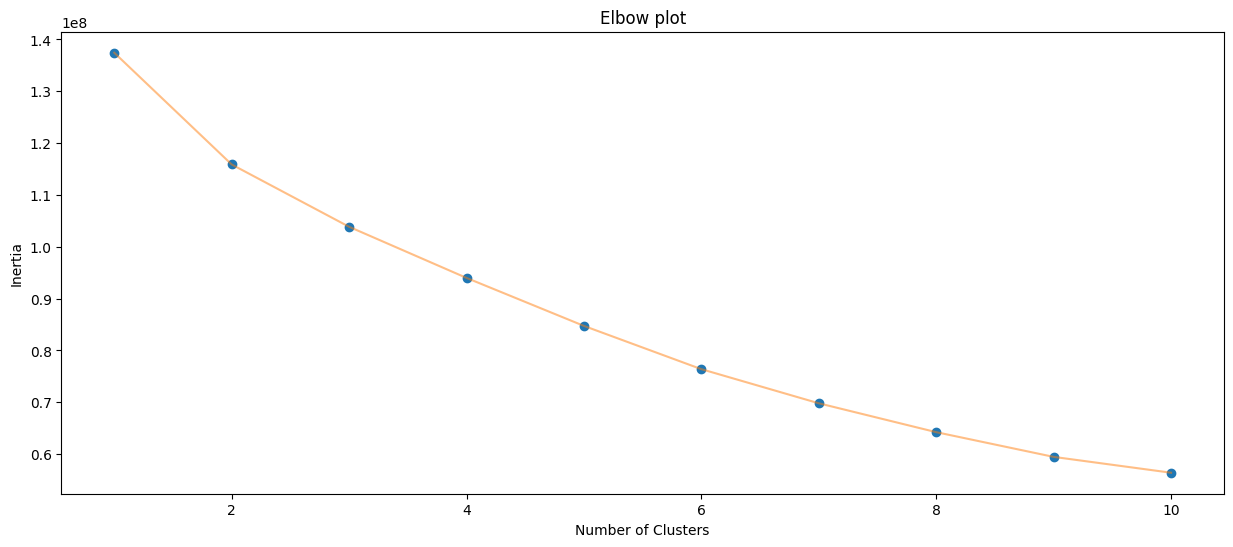

In [343]:
from sklearn.cluster import KMeans

def show_elbow_plot(data_final):
    inertia = []

    x = list(range(2, 12))

    for n_clusters in x:
        kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
        kmeans.fit(data_final)
        inertia.append(kmeans.inertia_)

    plt.figure(1 , figsize = figsize)
    plt.plot(np.arange(1 , 11) , inertia , 'o')
    plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
    plt.title('Elbow plot')
    plt.show()

In [ ]:
show_elbow_plot(data_final)